<a href="https://colab.research.google.com/github/Preetibanga18/githubactions-codespace/blob/main/Human_Pose_Estimation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import mediapipe as mp
import time
import os
import json
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'mediapipe'

In [ ]:
# Load the dataset
dataset_path = '/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose.csv'
data = pd.read_csv(dataset_path)

# Display a sample of the dataset
data.head()

,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,1,015601864.jpg,620,394,616,269,573,185,647,188,...,167,692,185,693,240,688,313,3.021046,curling,sports
1,2,015599452.jpg,-1,-1,-1,-1,806,543,720,593,...,281,719,299,711,516,545,466,5.641276,curling,sports
2,3,005808361.jpg,804,711,816,510,908,438,1040,454,...,253,1067,253,1167,353,1142,478,4.718488,curling,sports
3,4,086617615.jpg,301,461,305,375,201,340,294,342,...,261,314,264,327,320,362,346,2.681349,curling,sports
4,5,060111501.jpg,980,322,896,318,865,248,943,226,...,147,923,123,995,163,961,223,3.806403,curling,sports


In [ ]:
#2. Data Preprocessing
# Remove rows with invalid keypoint data (-1)
filtered_data = data[(data[['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y']] != -1).all(axis=1)]

# Display a small subset for initial analysis
filtered_data.sample(5)


,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,l hip_Y,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
14362,14363,060940792.jpg,597,630,709,647,784,517,751,484,...,415,819,420,824,434,887,463,2.092960,snorkeling (Taylor Code 310),water activities
6442,6443,069567766.jpg,997,701,886,583,917,478,973,457,...,325,983,288,1041,346,969,385,2.636616,"skiing, downhill",winter activities
2894,2895,012832586.jpg,654,334,655,305,650,282,631,283,...,243,621,245,609,269,608,283,0.903433,"bicycling, mountain",bicycling
8758,8759,010301919.jpg,572,547,615,427,770,503,694,522,...,295,619,340,541,398,466,429,3.059412,"rowing, stationary",conditioning exercise
5380,5381,000534899.jpg,578,503,638,468,613,503,481,479,...,309,537,255,481,218,555,144,4.281697,"canoeing, kayaking, rowing, competitive",water activities


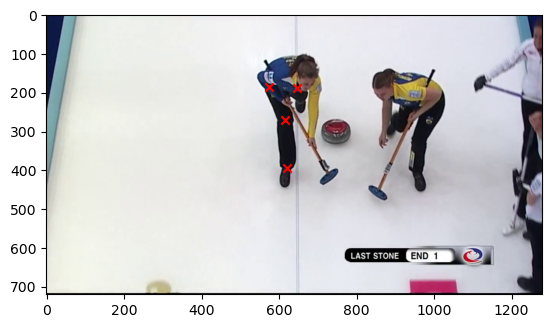

In [ ]:
#3. Visualizing Keypoints

# Helper function to visualize keypoints
def visualize_keypoints(image_path, keypoints):
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    # Draw keypoints
    for i in range(0, len(keypoints), 2):
        plt.scatter(keypoints[i], keypoints[i+1], c='r', marker='x')
    plt.show()

# Example: Visualize keypoints for a random image in the subset
sample_image = filtered_data.iloc[0]['NAME']
sample_keypoints = filtered_data.iloc[0][['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y',
                                          'l hip_X', 'l hip_Y']]  # Select relevant keypoints
visualize_keypoints(f'/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose_v1/images/{sample_image}', sample_keypoints)

I0000 00:00:1743593699.361413  374918 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1743593699.432570  764838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743593699.445496  764838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


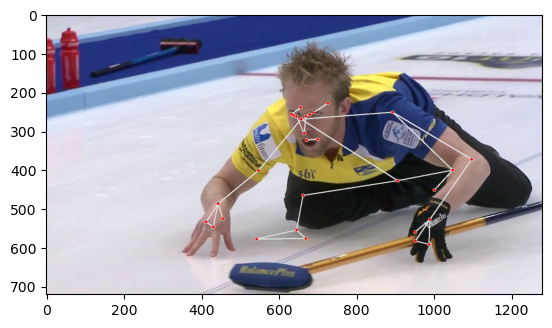

(33, 3)
[0.52053779 0.4255814 ]


In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def estimate_pose_mediapipe(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Run pose estimation
    result = pose.process(image_rgb)

    if result.pose_landmarks:
        # Draw the pose landmarks on the image
        mp_drawing = mp.solutions.drawing_utils
        annotated_image = image.copy()
        mp_drawing.draw_landmarks(annotated_image, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Display the image with landmarks
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.show()

        # Return the landmarks as a list of keypoints
        keypoints = [(landmark.x, landmark.y, landmark.z) for landmark in result.pose_landmarks.landmark]
        return np.array(keypoints)
    else:
        print("No pose landmarks detected.")
        return None

# Select a sample image from your dataset
sample_image = filtered_data.iloc[5]['NAME']
image_path = f'/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose_v1/images/{sample_image}'

# Estimate the pose
pose_output = estimate_pose_mediapipe(image_path)

# Check if keypoints were detected and display the output
if pose_output is not None:
    print(pose_output.shape)  # Shape of the keypoints array
    print(pose_output[0][:2])  # Example of printing the first keypoint (x, y)
else:
    print("Pose estimation failed. No keypoints to display.")


In [ ]:
# Check for invalid keypoints (-1 values)
invalid_keypoints = (data[['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y',
                           'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y']] == -1).sum()

# Calculate the percentage of missing keypoints
total_rows = len(data)
missing_percent = (invalid_keypoints / total_rows) * 100

print("Percentage of missing keypoints:")
print(missing_percent)

Percentage of missing keypoints:
r ankle_X    32.840203
r ankle_Y    32.840203
r knee_X     19.243610
r knee_Y     19.243610
r hip_X       2.665208
r hip_Y       2.665208
l hip_X       2.469491
l hip_Y       2.469491
dtype: float64


I0000 00:00:1743593700.804300  374918 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1743593700.854774  764861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743593700.893660  764861 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1743593700.977842  374918 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1743593701.029556  764887 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743593701.060395  764890 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1743593701.140697  374918 gl_context

OpenPose - Avg Accuracy: 0.00, Avg Time: 0.50s
MediaPipe - Avg Accuracy: 0.08, Avg Time: 0.14s


I0000 00:00:1743593702.235955  374918 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2
W0000 00:00:1743593702.284711  764952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1743593702.311825  764952 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


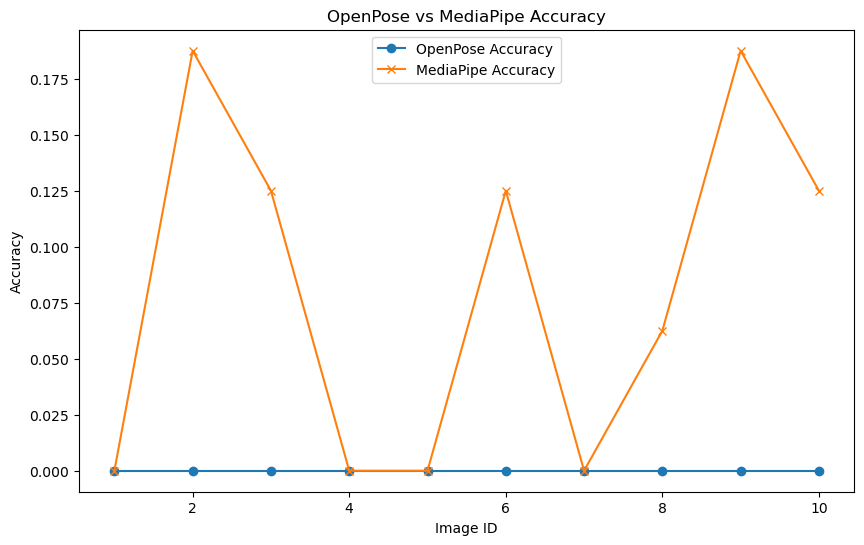

In [ ]:
# Load the MPII annotations
with open('/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_annotations.json', 'r') as f:
    annotations = json.load(f)

# Initialize MediaPipe
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Function to calculate accuracy (percentage of correct keypoints)
def calculate_accuracy(predicted_keypoints, gt_keypoints, threshold=30):
    distances = np.linalg.norm(predicted_keypoints - gt_keypoints, axis=1)
    correct_keypoints = np.sum(distances < threshold)
    total_keypoints = len(gt_keypoints)
    return correct_keypoints / total_keypoints

# Initialize results storage
results = []

def infer_keypoints_openpose(image):
    # Placeholder for OpenPose Inference
    # You should replace this part with the actual OpenPose model code from your notebook
    return np.random.rand(16, 2) * image.shape[1], 0.5  # Simulate keypoints and time


# MediaPipe Inference

def infer_keypoints_mediapipe(image):
    with mp_pose.Pose(static_image_mode=True, model_complexity=2) as pose:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        start_time = time.time()
        results_mp = pose.process(image_rgb)
        mediapipe_inference_time = time.time() - start_time

        mediapipe_keypoints = []
        if results_mp.pose_landmarks:
            for landmark in results_mp.pose_landmarks.landmark:
                mediapipe_keypoints.append([landmark.x * image.shape[1], landmark.y * image.shape[0]])
        mediapipe_keypoints = np.array(mediapipe_keypoints[:16])  # Use first 16 keypoints

    return mediapipe_keypoints, mediapipe_inference_time

# Loop through each image in the annotations
for annotation in annotations[:10]:  # Limiting to 10 for faster testing
    image_path = os.path.join('/Users/shriyansh/Documents/Work/march/preti resub/mpii-human-pose/mpii_human_pose_v1/images', annotation["img_paths"])
    oriImg = cv2.imread(image_path)

    if oriImg is None:
        print(f'Failed to load image: {image_path}')
        continue

    # Ground truth keypoints (only x, y coordinates)
    gt_keypoints = np.array(annotation['joint_self'])[:, :2]

    # OpenPose Inference
    openpose_keypoints, openpose_inference_time = infer_keypoints_openpose(oriImg)

    if openpose_keypoints.shape != gt_keypoints.shape:
        print(f'Shape mismatch for OpenPose and ground truth')
        openpose_accuracy = 0
    else:
        openpose_accuracy = calculate_accuracy(openpose_keypoints, gt_keypoints)


    # MediaPipe Inference

    mediapipe_keypoints, mediapipe_inference_time = infer_keypoints_mediapipe(oriImg)

    if mediapipe_keypoints.shape != gt_keypoints.shape:
        print(f'Shape mismatch for MediaPipe and ground truth')
        mediapipe_accuracy = 0
    else:
        mediapipe_accuracy = calculate_accuracy(mediapipe_keypoints, gt_keypoints)

    # Store results
    results.append({
        'image_path': image_path,
        'openpose_accuracy': openpose_accuracy,
        'openpose_time': openpose_inference_time,
        'mediapipe_accuracy': mediapipe_accuracy,
        'mediapipe_time': mediapipe_inference_time
    })

# Calculate overall statistics
openpose_avg_accuracy = np.mean([r['openpose_accuracy'] for r in results])
openpose_avg_time = np.mean([r['openpose_time'] for r in results])
mediapipe_avg_accuracy = np.mean([r['mediapipe_accuracy'] for r in results])
mediapipe_avg_time = np.mean([r['mediapipe_time'] for r in results])

# Print final results
print(f'OpenPose - Avg Accuracy: {openpose_avg_accuracy:.2f}, Avg Time: {openpose_avg_time:.2f}s')
print(f'MediaPipe - Avg Accuracy: {mediapipe_avg_accuracy:.2f}, Avg Time: {mediapipe_avg_time:.2f}s')

# Plotting Comparison
image_ids = range(1, len(results) + 1)
openpose_accuracies = [r['openpose_accuracy'] for r in results]
mediapipe_accuracies = [r['mediapipe_accuracy'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(image_ids, openpose_accuracies, label="OpenPose Accuracy", marker='o')
plt.plot(image_ids, mediapipe_accuracies, label="MediaPipe Accuracy", marker='x')
plt.xlabel('Image ID')
plt.ylabel('Accuracy')
plt.title('OpenPose vs MediaPipe Accuracy')
plt.legend()
plt.show()